# CUBEM 2019 Part 2 Preprocessing
## Multi-Floor Data Processing (Floors 3, 4, 5, 6, 7)



In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Load and Combine Floor Data

We'll load floors 3, 4, and 5 and combine them into a single dataframe for efficient preprocessing.


In [36]:

print("Loading floor data...")
df_floor3 = pd.read_csv('../data/cu-bem/2019Floor3.csv/2019Floor3.csv')
df_floor4 = pd.read_csv('../data/cu-bem/2019Floor4.csv/2019Floor4.csv')
df_floor5 = pd.read_csv('../data/cu-bem/2019Floor5.csv/2019Floor5.csv')
df_floor6 = pd.read_csv('../data/cu-bem/2019Floor6.csv/2019Floor6.csv')
df_floor7 = pd.read_csv('../data/cu-bem/2019Floor7.csv/2019Floor7.csv')

print(f"Floor 3 shape: {df_floor3.shape}")
print(f"Floor 4 shape: {df_floor4.shape}")
print(f"Floor 5 shape: {df_floor5.shape}")
print(f"Floor 6 shape: {df_floor6.shape}")
print(f"Floor 7 shape: {df_floor7.shape}")

df_floor3['floor'] = 3
df_floor4['floor'] = 4
df_floor5['floor'] = 5
df_floor6['floor'] = 6
df_floor7['floor'] = 7

# Combine all floors into one dataframe
df_combined = pd.concat([df_floor3, df_floor4, df_floor5, df_floor6, df_floor7], ignore_index=True)

print(f"\nCombined dataset shape: {df_combined.shape}")
print(f"Floor distribution:")
print(df_combined['floor'].value_counts().sort_index())


Loading floor data...
Floor 3 shape: (525600, 30)
Floor 4 shape: (525600, 30)
Floor 5 shape: (525600, 30)
Floor 6 shape: (424169, 30)
Floor 7 shape: (525600, 30)

Combined dataset shape: (2526569, 34)
Floor distribution:
floor
3    525600
4    525600
5    525600
6    424169
7    525600
Name: count, dtype: int64


In [37]:
## Dataset Overview and Useful Information

print("Dataset Overview")
print("="*50)
print(f"Total shape: {df_combined.shape}")
print(f"Memory usage: {df_combined.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nColumn information:")
print(f"Total columns: {len(df_combined.columns)}")
print(f"Numeric columns: {len(df_combined.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical columns: {len(df_combined.select_dtypes(include=['object']).columns)}")

print(f"\nData types:")
print(df_combined.dtypes.value_counts())

print(f"\nFloor distribution:")
print(df_combined['floor'].value_counts().sort_index())

print(f"\nTime range (if datetime column exists):")
if 'datetime' in df_combined.columns:
    print(f"From: {df_combined['datetime'].min()}")
    print(f"To: {df_combined['datetime'].max()}")
else:
    print("No datetime column found")

print(f"\nBasic statistics for numeric columns:")
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns
print(df_combined[numeric_cols].describe())


Dataset Overview
Total shape: (2526569, 34)
Memory usage: 799.96 MB

Column information:
Total columns: 34
Numeric columns: 33
Categorical columns: 1

Data types:
float64    32
object      1
int64       1
Name: count, dtype: int64

Floor distribution:
floor
3    525600
4    525600
5    525600
6    424169
7    525600
Name: count, dtype: int64

Time range (if datetime column exists):
No datetime column found

Basic statistics for numeric columns:
         z1_AC1(kW)    z1_AC2(kW)    z1_AC3(kW)    z1_AC4(kW)  z1_Light(kW)  \
count  2.376843e+06  1.953283e+06  1.953283e+06  1.994512e+06  2.489151e+06   
mean   7.623618e-01  2.010819e-02  2.044715e-02  5.813714e+00  1.421251e+00   
std    3.998853e+00  1.158375e-01  1.022144e-01  1.172501e+01  1.865863e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  

In [38]:
## Handle Duplicates

print("Duplicate Analysis")
print("="*50)

# Check for duplicate rows
duplicate_rows = df_combined.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

if duplicate_rows > 0:
    print(f"Percentage of duplicates: {(duplicate_rows / len(df_combined)) * 100:.2f}%")
    
    # Remove duplicates
    df_combined = df_combined.drop_duplicates()
    print(f"Shape after removing duplicates: {df_combined.shape}")
else:
    print("No duplicate rows found")

# Check for duplicate columns
duplicate_cols = df_combined.columns.duplicated().sum()
print(f"Number of duplicate columns: {duplicate_cols}")

if duplicate_cols > 0:
    df_combined = df_combined.loc[:, ~df_combined.columns.duplicated()]
    print(f"Shape after removing duplicate columns: {df_combined.shape}")
else:
    print("No duplicate columns found")


Duplicate Analysis
Number of duplicate rows: 0
No duplicate rows found
Number of duplicate columns: 0
No duplicate columns found


## Step 1: Missing Values Handling


In [39]:
# Create a copy for preprocessing
df_processed = df_combined.copy()

print("Step 1: Missing Values Analysis")
print("="*50)
print(f"Initial shape: {df_processed.shape}")


Step 1: Missing Values Analysis
Initial shape: (2526569, 34)


In [40]:
# Calculate missing values with percentages
print("Missing values per column:")
missing_per_column = df_processed.isnull().sum()
missing_percentage = (missing_per_column / len(df_processed)) * 100

missing_info = pd.DataFrame({
    'Missing_Count': missing_per_column,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Percentage', ascending=False)

# Only show columns with missing values
missing_info = missing_info[missing_info['Missing_Count'] > 0]
print(missing_info)


Missing values per column:
              Missing_Count  Missing_Percentage
z4_AC2(kW)          2103113           83.239880
z4_AC3(kW)          2103113           83.239880
z4_AC4(kW)          2103008           83.235724
z2_S1(RH%)           672780           26.628206
z2_S1(lux)           672779           26.628166
z2_S1(degC)          672775           26.628008
z4_S1(lux)           628324           24.868666
z4_S1(RH%)           628324           24.868666
z4_S1(degC)          628323           24.868626
z1_S1(lux)           604755           23.935820
z1_S1(degC)          604751           23.935661
z1_S1(RH%)           604749           23.935582
z5_S1(RH%)           577146           22.843073
z5_S1(degC)          577139           22.842796
z5_S1(lux)           577139           22.842796
z1_AC3(kW)           573286           22.690297
z1_AC2(kW)           573286           22.690297
z1_AC4(kW)           532057           21.058479
z1_AC1(kW)           149726            5.926060
z2_AC1(kW)   

In [41]:
# Overall missing values summary
print("Overall Missing Values Summary:")
print("="*40)
print(f"Total missing values: {df_processed.isnull().sum().sum():,}")
print(f"Overall percentage of missing values: {(df_processed.isnull().sum().sum() / (df_processed.shape[0] * df_processed.shape[1])) * 100:.2f}%")
print(f"Columns with missing values: {len(missing_info)}")
print(f"Columns without missing values: {df_processed.shape[1] - len(missing_info)}")


Overall Missing Values Summary:
Total missing values: 16,138,163
Overall percentage of missing values: 18.79%
Columns with missing values: 32
Columns without missing values: 2


In [42]:
# Remove columns with over 80% missing values
print("Removing columns with over 80% missing values...")
print("="*50)

high_missing_cols = missing_info[missing_info['Missing_Percentage'] > 80].index.tolist()

if high_missing_cols:
    print(f"Columns to remove: {high_missing_cols}")
    print(f"Number of columns to remove: {len(high_missing_cols)}")
    
    # Show details of columns being removed
    print("\nDetails of columns being removed:")
    for col in high_missing_cols:
        missing_pct = missing_info.loc[col, 'Missing_Percentage']
        missing_count = missing_info.loc[col, 'Missing_Count']
        print(f"  {col}: {missing_count:,} missing ({missing_pct:.2f}%)")
    
    df_processed = df_processed.drop(columns=high_missing_cols)
    print(f"\nShape after removing high missing columns: {df_processed.shape}")
else:
    print("No columns with over 80% missing values found")


Removing columns with over 80% missing values...
Columns to remove: ['z4_AC2(kW)', 'z4_AC3(kW)', 'z4_AC4(kW)']
Number of columns to remove: 3

Details of columns being removed:
  z4_AC2(kW): 2,103,113 missing (83.24%)
  z4_AC3(kW): 2,103,113 missing (83.24%)
  z4_AC4(kW): 2,103,008 missing (83.24%)

Shape after removing high missing columns: (2526569, 31)


In [43]:
# Fill remaining missing values with mode
print("Filling remaining missing values with mode...")
print("="*50)

# Check remaining missing values after column removal
remaining_missing = df_processed.isnull().sum()
remaining_missing_info = remaining_missing[remaining_missing > 0]

if len(remaining_missing_info) > 0:
    print(f"Columns still with missing values: {len(remaining_missing_info)}")
    print("\nRemaining missing values:")
    for col, count in remaining_missing_info.items():
        pct = (count / len(df_processed)) * 100
        print(f"  {col}: {count:,} missing ({pct:.2f}%)")
    
    print("\nFilling missing values...")
    filled_count = 0
    
    # For all columns, fill with mode
    for col in df_processed.columns:
        missing_count = df_processed[col].isnull().sum()
        if missing_count > 0:
            if df_processed[col].dtype in ['object', 'category']:
                # For categorical columns, use mode
                mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
                df_processed[col] = df_processed[col].fillna(mode_value)
                print(f"  {col}: Filled {missing_count:,} missing values with mode: '{mode_value}'")
            else:
                # For numeric columns, also use mode
                mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else df_processed[col].median()
                df_processed[col] = df_processed[col].fillna(mode_value)
                print(f"  {col}: Filled {missing_count:,} missing values with mode: {mode_value:.2f}")
            filled_count += missing_count
    
    print(f"\nTotal missing values filled: {filled_count:,}")
else:
    print("No missing values remaining after column removal")


Filling remaining missing values with mode...
Columns still with missing values: 29

Remaining missing values:
  z1_AC1(kW): 149,726 missing (5.93%)
  z1_AC2(kW): 573,286 missing (22.69%)
  z1_AC3(kW): 573,286 missing (22.69%)
  z1_AC4(kW): 532,057 missing (21.06%)
  z1_Light(kW): 37,418 missing (1.48%)
  z1_Plug(kW): 3,270 missing (0.13%)
  z1_S1(degC): 604,751 missing (23.94%)
  z1_S1(RH%): 604,749 missing (23.94%)
  z1_S1(lux): 604,755 missing (23.94%)
  z2_AC1(kW): 108,429 missing (4.29%)
  z2_Light(kW): 58,676 missing (2.32%)
  z2_Plug(kW): 58,291 missing (2.31%)
  z2_S1(degC): 672,775 missing (26.63%)
  z2_S1(RH%): 672,780 missing (26.63%)
  z2_S1(lux): 672,779 missing (26.63%)
  z3_Light(kW): 5,702 missing (0.23%)
  z3_Plug(kW): 5,878 missing (0.23%)
  z4_AC1(kW): 108,372 missing (4.29%)
  z4_Light(kW): 21,413 missing (0.85%)
  z4_Plug(kW): 8,445 missing (0.33%)
  z4_S1(degC): 628,323 missing (24.87%)
  z4_S1(RH%): 628,324 missing (24.87%)
  z4_S1(lux): 628,324 missing (24.87%)


## Time Series Processing

Now we'll convert the processed data into a proper time series format for temporal analysis.


In [44]:
# Detect time-related columns
print("Detecting Time-Related Columns")
print("="*40)

time_columns = []
for col in df_processed.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['time', 'date', 'timestamp', 'datetime', 'hour', 'day', 'month', 'year']):
        time_columns.append(col)

print("Potential time-related columns:")
print("-" * 30)
if time_columns:
    for col in time_columns:
        print(f"{col}: {df_processed[col].head(3).tolist()}")
        print(f"  Data type: {df_processed[col].dtype}")
        print(f"  Unique values: {df_processed[col].nunique()}")
        print()
else:
    print("No obvious time columns found in the dataset")
    print("Available columns:")
    for col in df_processed.columns:
        print(f"  {col}")


Detecting Time-Related Columns
Potential time-related columns:
------------------------------
Date: ['2019-01-01 00:00:00', '2019-01-01 00:01:00', '2019-01-01 00:02:00']
  Data type: object
  Unique values: 525601



In [45]:
# Convert to time series format
print("Converting to Time Series Format")
print("="*40)

# Create a copy for time series processing
df_timeseries = df_processed.copy()

if time_columns:
    # Use the first time column found
    time_col = time_columns[0]
    print(f"Using '{time_col}' as the time column")
    
    # Convert to datetime with error handling
    try:
        # Try different datetime conversion methods
        print("Attempting datetime conversion...")
        
        # First try with mixed format
        df_timeseries[time_col] = pd.to_datetime(df_timeseries[time_col], format='mixed', errors='coerce')
        
        # Check if conversion was successful
        if df_timeseries[time_col].isna().sum() > 0:
            print(f"Warning: {df_timeseries[time_col].isna().sum()} values could not be converted to datetime")
            # Drop rows with invalid datetime values
            df_timeseries = df_timeseries.dropna(subset=[time_col])
            print(f"Dropped rows with invalid datetime values. New shape: {df_timeseries.shape}")
        
        print(f"Successfully converted {time_col} to datetime")
        
        # Set as index
        df_timeseries = df_timeseries.set_index(time_col)
        print(f"Set {time_col} as index")
        print(f"Time range: {df_timeseries.index.min()} to {df_timeseries.index.max()}")
        
    except Exception as e:
        print(f"Error converting {time_col} to datetime: {e}")
        print("Creating a sequential hourly time index instead...")
        
        # Create a more manageable date range
        start_date = pd.Timestamp('2019-01-01')
        df_timeseries.index = pd.date_range(start=start_date, periods=len(df_timeseries), freq='H')
        print(f"Created hourly time index from 2019-01-01")
        
else:
    print("No time columns found. Creating a sequential hourly time index...")
    
    # Create a more manageable date range
    start_date = pd.Timestamp('2019-01-01')
    df_timeseries.index = pd.date_range(start=start_date, periods=len(df_timeseries), freq='H')
    print(f"Created hourly time index from 2019-01-01")

print(f"\nFinal time series shape: {df_timeseries.shape}")
print(f"Index type: {type(df_timeseries.index)}")


Converting to Time Series Format
Using 'Date' as the time column
Attempting datetime conversion...
Dropped rows with invalid datetime values. New shape: (2526568, 31)
Successfully converted Date to datetime
Set Date as index
Time range: 2019-01-01 00:00:00 to 2019-12-31 23:59:00

Final time series shape: (2526568, 30)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [46]:
# Time series statistics and information
print("Time Series Dataset Information")
print("="*50)

print(f"Shape: {df_timeseries.shape}")
print(f"Index type: {type(df_timeseries.index)}")
print(f"Frequency: {pd.infer_freq(df_timeseries.index)}")

print(f"\nTime Series Statistics:")
print("-" * 30)
print(f"Start time: {df_timeseries.index.min()}")
print(f"End time: {df_timeseries.index.max()}")
print(f"Duration: {df_timeseries.index.max() - df_timeseries.index.min()}")
print(f"Total observations: {len(df_timeseries):,}")

# Check for missing time periods
print(f"\nTime Series Completeness:")
print("-" * 30)
expected_freq = pd.infer_freq(df_timeseries.index)
if expected_freq:
    expected_range = pd.date_range(start=df_timeseries.index.min(), 
                                  end=df_timeseries.index.max(), 
                                  freq=expected_freq)
    missing_periods = len(expected_range) - len(df_timeseries)
    print(f"Expected observations: {len(expected_range):,}")
    print(f"Actual observations: {len(df_timeseries):,}")
    print(f"Missing periods: {missing_periods:,}")
    if missing_periods == 0:
        print("Time series is complete - no missing periods")
    else:
        print("Time series has missing periods")
else:
    print("Could not infer frequency - checking for gaps...")
    time_diffs = df_timeseries.index.to_series().diff()
    unique_diffs = time_diffs.value_counts().head(5)
    print("Most common time differences:")
    for diff, count in unique_diffs.items():
        print(f"  {diff}: {count} occurrences")

# Floor distribution in time series
print(f"\nFloor Distribution in Time Series:")
print("-" * 30)
if 'floor' in df_timeseries.columns:
    floor_dist = df_timeseries['floor'].value_counts().sort_index()
    for floor, count in floor_dist.items():
        print(f"Floor {floor}: {count:,} observations")
else:
    print("Floor column not found in time series data")


Time Series Dataset Information
Shape: (2526568, 30)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Frequency: None

Time Series Statistics:
------------------------------
Start time: 2019-01-01 00:00:00
End time: 2019-12-31 23:59:00
Duration: 364 days 23:59:00
Total observations: 2,526,568

Time Series Completeness:
------------------------------
Could not infer frequency - checking for gaps...
Most common time differences:
  0 days 00:01:00: 2526563 occurrences
  -365 days +00:01:00: 3 occurrences
  -295 days +10:33:00: 1 occurrences

Floor Distribution in Time Series:
------------------------------
Floor 3: 525,600 observations
Floor 4: 525,600 observations
Floor 5: 525,600 observations
Floor 6: 424,168 observations
Floor 7: 525,600 observations


In [47]:
# Time series processing summary
print("Time Series Processing Summary")
print("="*50)

print(f"Time series processing completed successfully!")
print(f"Dataset shape: {df_timeseries.shape}")
print(f"Time range: {df_timeseries.index.min()} to {df_timeseries.index.max()}")
print(f"Total observations: {len(df_timeseries):,}")

# Select numeric columns for time series analysis
numeric_cols_ts = df_timeseries.select_dtypes(include=[np.number]).columns
print(f"Numeric columns available for analysis: {len(numeric_cols_ts)}")

if len(numeric_cols_ts) > 0:
    print(f"\nNumeric columns for time series analysis:")
    for i, col in enumerate(numeric_cols_ts, 1):
        print(f"  {i:2d}. {col}")
    
    print(f"\nTime series processing completed successfully!")
    print(f"Dataset is now ready for:")
    print("  - Temporal analysis and visualization")
    print("  - Time series forecasting")
    print("  - Seasonal pattern detection")
    print("  - Trend analysis")
    print("  - Multi-floor comparative analysis")
else:
    print("No numeric columns found for time series analysis")

print(f"\nFinal processed dataset: 'df_timeseries'")
print(f"Original processed dataset: 'df_processed'")


Time Series Processing Summary
Time series processing completed successfully!
Dataset shape: (2526568, 30)
Time range: 2019-01-01 00:00:00 to 2019-12-31 23:59:00
Total observations: 2,526,568
Numeric columns available for analysis: 30

Numeric columns for time series analysis:
   1. z1_AC1(kW)
   2. z1_AC2(kW)
   3. z1_AC3(kW)
   4. z1_AC4(kW)
   5. z1_Light(kW)
   6. z1_Plug(kW)
   7. z1_S1(degC)
   8. z1_S1(RH%)
   9. z1_S1(lux)
  10. z2_AC1(kW)
  11. z2_Light(kW)
  12. z2_Plug(kW)
  13. z2_S1(degC)
  14. z2_S1(RH%)
  15. z2_S1(lux)
  16. z3_Light(kW)
  17. z3_Plug(kW)
  18. z4_AC1(kW)
  19. z4_Light(kW)
  20. z4_Plug(kW)
  21. z4_S1(degC)
  22. z4_S1(RH%)
  23. z4_S1(lux)
  24. z5_AC1(kW)
  25. z5_Light(kW)
  26. z5_Plug(kW)
  27. z5_S1(degC)
  28. z5_S1(RH%)
  29. z5_S1(lux)
  30. floor

Time series processing completed successfully!
Dataset is now ready for:
  - Temporal analysis and visualization
  - Time series forecasting
  - Seasonal pattern detection
  - Trend analysis
  - Mu

## Outlier Detection and Treatment

Now we'll analyze and handle outliers in the time series data to ensure data quality for analysis.


In [48]:
# Outlier Detection Analysis
print("Outlier Detection Analysis:")
print("=" * 50)

# Select numeric columns for outlier analysis (excluding floor)
numeric_cols = df_timeseries.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != 'floor']

print(f"Numeric columns for outlier analysis: {len(numeric_cols)}")
print(f"Columns: {list(numeric_cols)}")

if len(numeric_cols) > 0:
    # Z-Score Analysis
    print(f"\nZ-Score Outlier Detection:")
    print("-" * 40)
    
    # Calculate z-scores for all numeric columns
    z_scores_df = pd.DataFrame(
        np.abs(stats.zscore(df_timeseries[numeric_cols])),
        columns=numeric_cols
    )
    
    # Define outlier threshold (typically 2 or 3)
    outlier_threshold = 3
    outliers_summary = {}
    
    for col in numeric_cols:
        outlier_mask = z_scores_df[col] > outlier_threshold
        outlier_count = outlier_mask.sum()
        outlier_percentage = (outlier_count / len(df_timeseries)) * 100
        
        outliers_summary[col] = {
            'count': outlier_count,
            'percentage': outlier_percentage,
            'max_z_score': z_scores_df[col].max()
        }
        
        print(f"{col}:")
        print(f"  Outliers (z-score > {outlier_threshold}): {outlier_count} ({outlier_percentage:.2f}%)")
        print(f"  Max z-score: {z_scores_df[col].max():.2f}")
    
    # Summary statistics
    total_outliers = sum([info['count'] for info in outliers_summary.values()])
    print(f"\nTotal outliers across all columns: {total_outliers}")
    
else:
    print("No numeric columns found for outlier analysis")


Outlier Detection Analysis:
Numeric columns for outlier analysis: 29
Columns: ['z1_AC1(kW)', 'z1_AC2(kW)', 'z1_AC3(kW)', 'z1_AC4(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']

Z-Score Outlier Detection:
----------------------------------------
z1_AC1(kW):
  Outliers (z-score > 3): 80962 (3.20%)
  Max z-score: 13.04
z1_AC2(kW):
  Outliers (z-score > 3): 8295 (0.33%)
  Max z-score: 52.88
z1_AC3(kW):
  Outliers (z-score > 3): 17617 (0.70%)
  Max z-score: 35.27
z1_AC4(kW):
  Outliers (z-score > 3): 25799 (1.02%)
  Max z-score: 5.07
z1_Light(kW):
  Outliers (z-score > 3): 788 (0.03%)
  Max z-score: 47.03
z1_Plug(kW):
  Outliers (z-score > 3): 92500 (3.66%)
  Max z-sco

Creating Outlier Visualizations:


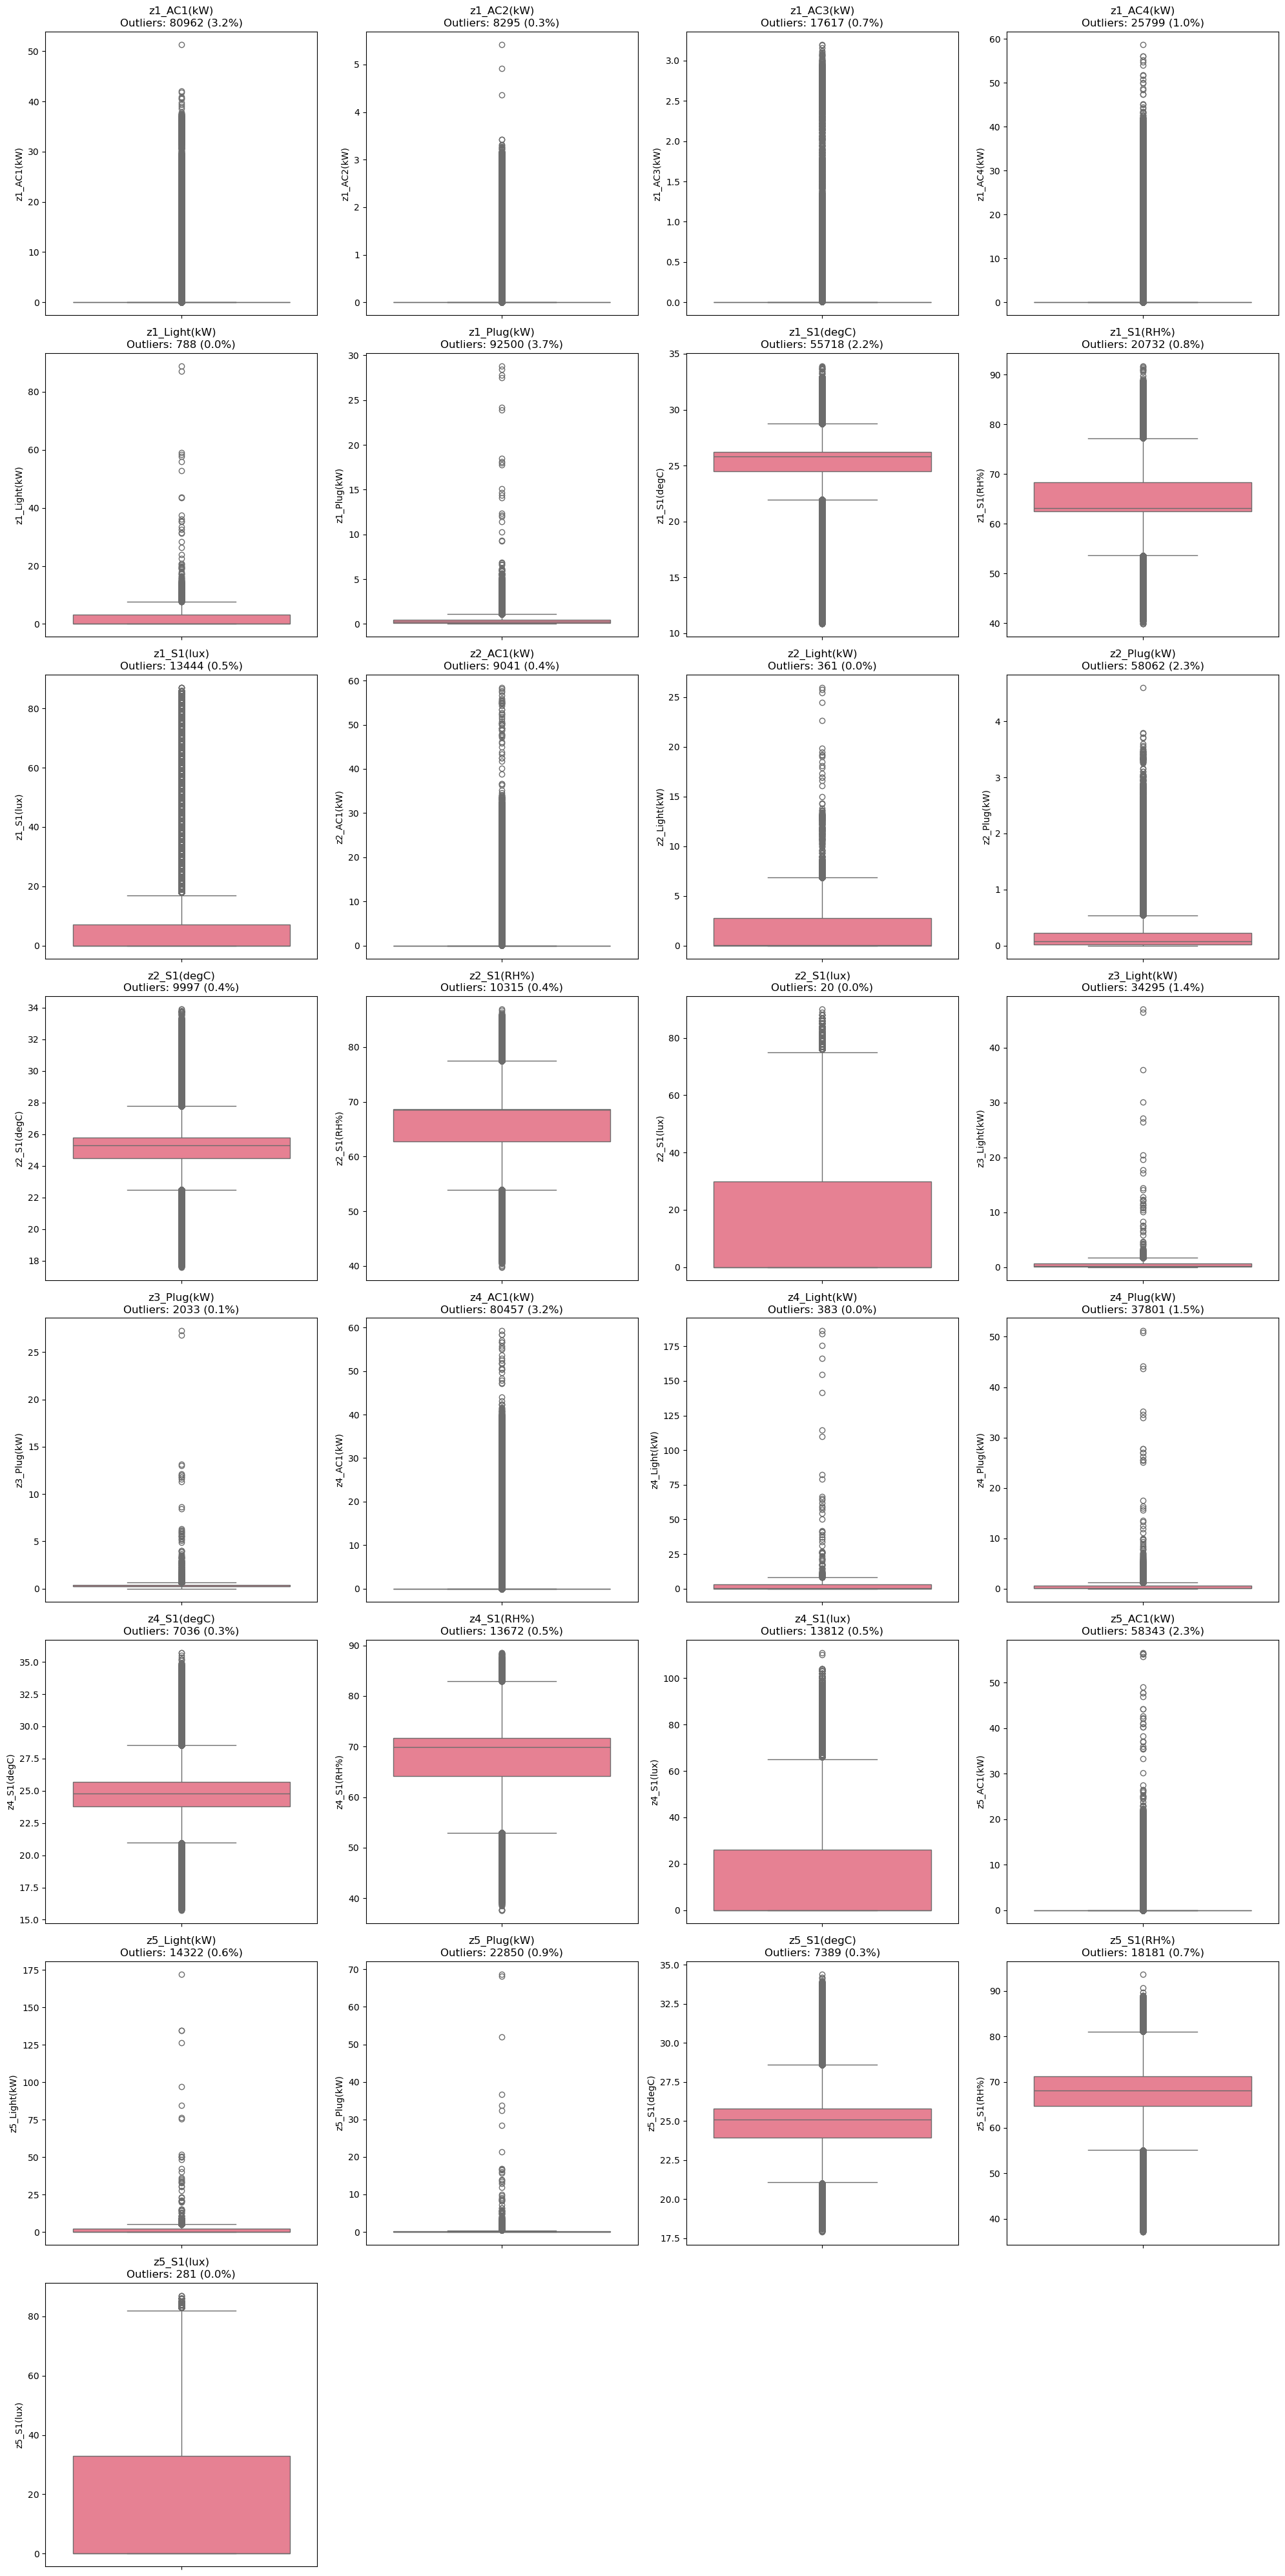


Distribution Plots for Columns with Outliers:
--------------------------------------------------


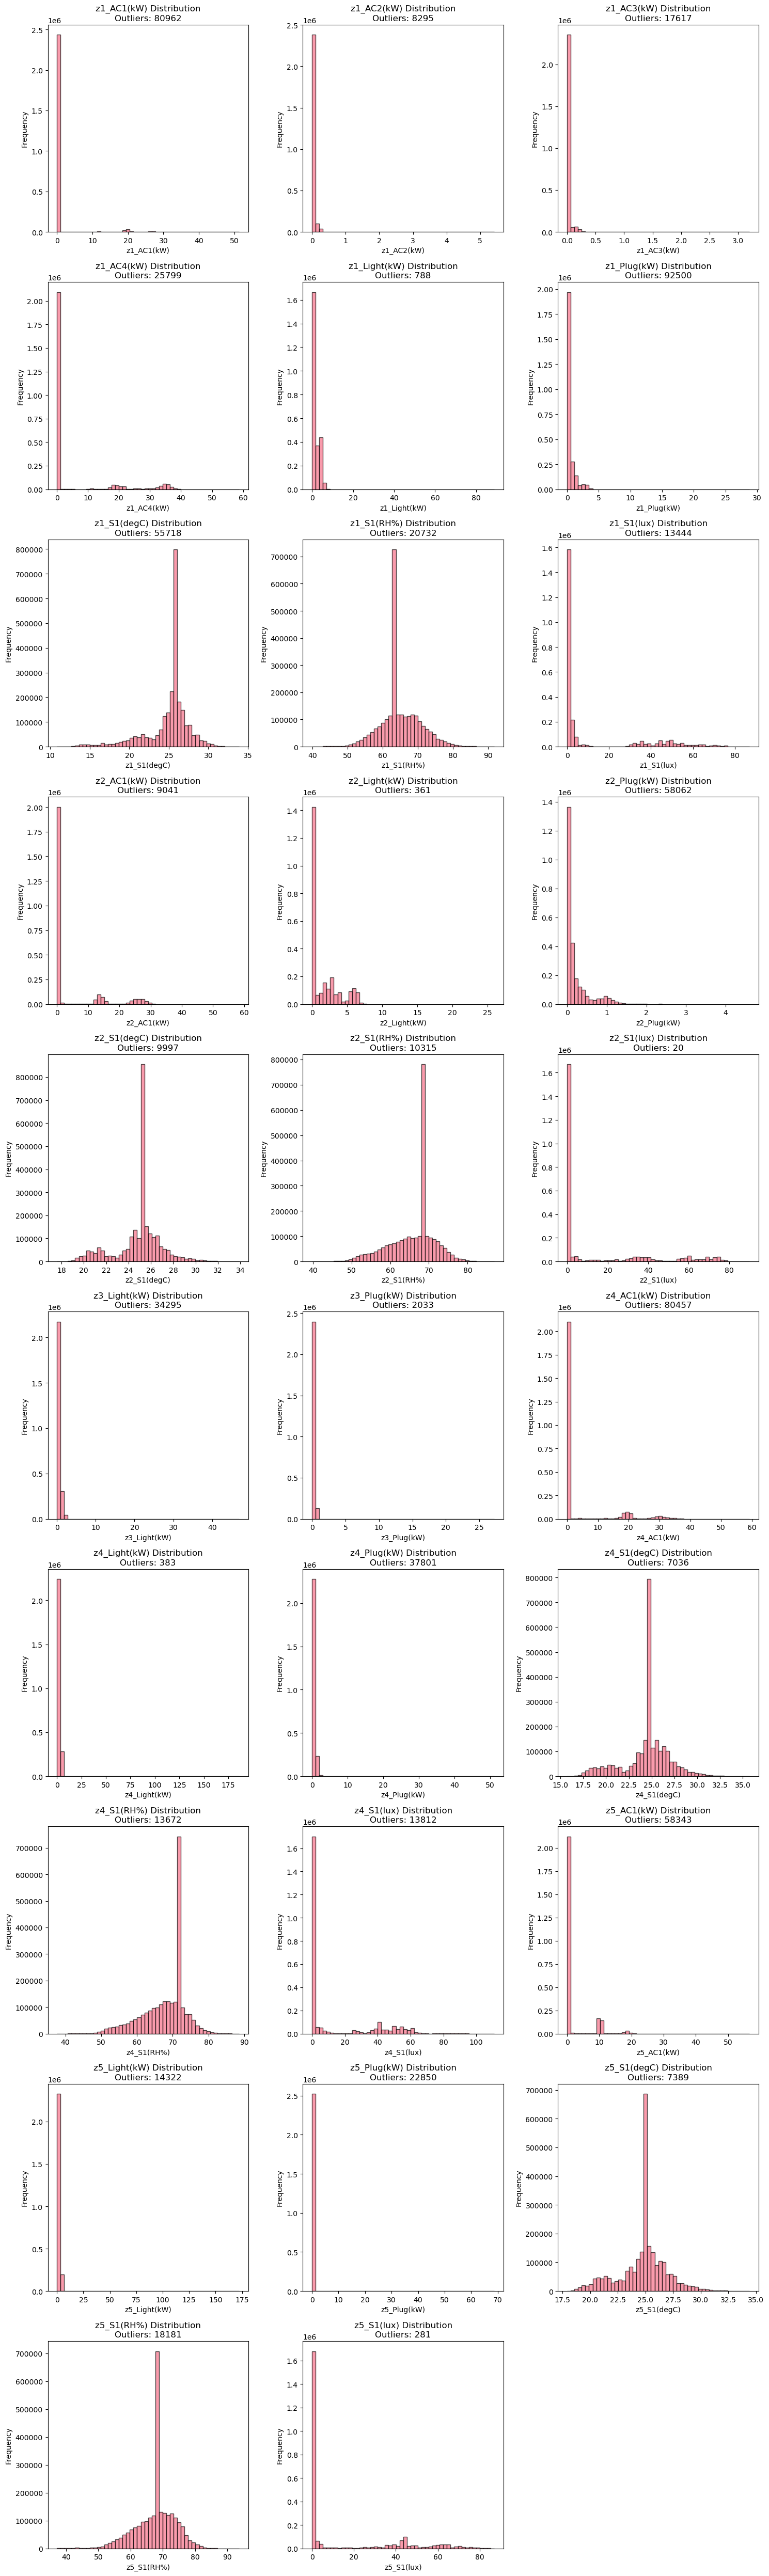


Outlier detection and visualization completed!


In [49]:
# Outlier Visualization
if len(numeric_cols) > 0:
    print("Creating Outlier Visualizations:")
    print("=" * 40)
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create box plots for all numeric columns
    n_cols = 4
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else [axes]
    
    for i, col in enumerate(numeric_cols):
        row = i // n_cols
        col_idx = i % n_cols
        ax = axes[row, col_idx]
        
        # Create box plot
        sns.boxplot(data=df_timeseries, y=col, ax=ax)
        ax.set_title(f'{col}\nOutliers: {outliers_summary[col]["count"]} ({outliers_summary[col]["percentage"]:.1f}%)')
        ax.tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for i in range(len(numeric_cols), n_rows * n_cols):
        row = i // n_cols
        col_idx = i % n_cols
        axes[row, col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Create distribution plots for columns with outliers
    print(f"\nDistribution Plots for Columns with Outliers:")
    print("-" * 50)
    
    columns_with_outliers = [col for col in numeric_cols if outliers_summary[col]['count'] > 0]
    
    if len(columns_with_outliers) > 0:
        n_dist_cols = min(3, len(columns_with_outliers))
        n_dist_rows = (len(columns_with_outliers) + n_dist_cols - 1) // n_dist_cols
        
        fig, axes = plt.subplots(n_dist_rows, n_dist_cols, figsize=(15, 5*n_dist_rows))
        if n_dist_rows == 1:
            axes = axes.reshape(1, -1) if n_dist_cols > 1 else [axes]
        
        for i, col in enumerate(columns_with_outliers):
            row = i // n_dist_cols
            col_idx = i % n_dist_cols
            ax = axes[row, col_idx]
            
            # Create histogram
            ax.hist(df_timeseries[col].dropna(), bins=50, alpha=0.7, edgecolor='black')
            ax.set_title(f'{col} Distribution\nOutliers: {outliers_summary[col]["count"]}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
        
        # Hide empty subplots
        for i in range(len(columns_with_outliers), n_dist_rows * n_dist_cols):
            row = i // n_dist_cols
            col_idx = i % n_dist_cols
            axes[row, col_idx].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    print(f"\nOutlier detection and visualization completed!")
    
else:
    print("No numeric columns found for outlier visualization")


In [50]:
# COMMENTED OUT - Outlier Treatment - Winsorization
"""
print("Outlier Treatment - Winsorization:")
print("=" * 40)

if len(numeric_cols) > 0:
    # Winsorization: Cap outliers at 95th and 5th percentiles
    print("Applying winsorization to outliers...")
    print("-" * 40)
    
    df_winsorized = df_timeseries.copy()
    winsorized_count = 0
    
    for col in numeric_cols:
        if outliers_summary[col]['count'] > 0:
            # Calculate percentiles for winsorization
            p5 = df_winsorized[col].quantile(0.05)
            p95 = df_winsorized[col].quantile(0.95)
            
            # Count outliers before winsorization
            outliers_before = ((df_winsorized[col] < p5) | (df_winsorized[col] > p95)).sum()
            
            # Apply winsorization (cap outliers)
            df_winsorized[col] = df_winsorized[col].clip(lower=p5, upper=p95)
            
            winsorized_count += outliers_before
            print(f"{col}: Winsorized {outliers_before} outliers (5th-95th percentile: {p5:.2f} to {p95:.2f})")
    
    print(f"\nTotal outliers winsorized: {winsorized_count}")
    print(f"Shape after winsorization: {df_winsorized.shape}")
    
    # Summary
    print(f"\nWinsorization Summary:")
    print("-" * 30)
    print(f"Original dataset shape: {df_timeseries.shape}")
    print(f"Winsorized dataset shape: {df_winsorized.shape}")
    print(f"Total outliers detected: {total_outliers}")
    print(f"Outliers winsorized: {winsorized_count}")
    
    # Use winsorized dataset for further analysis
    print(f"\nUsing winsorized dataset for further analysis...")
    df_timeseries_final = df_winsorized
    
else:
    print("No numeric columns found for outlier treatment")
    df_timeseries_final = df_timeseries
"""

# Skip outlier treatment for now - use original time series data
print("Skipping outlier treatment - using original time series data")
df_timeseries_final = df_timeseries


Skipping outlier treatment - using original time series data
